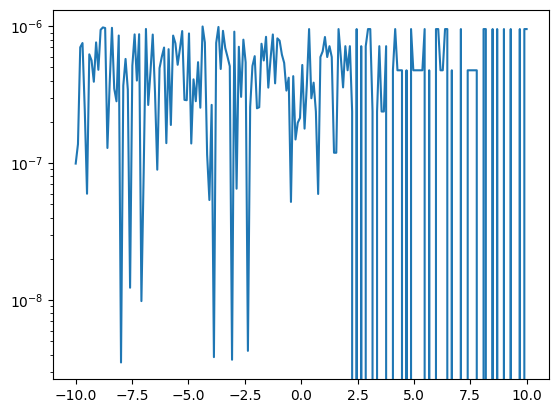

In [20]:
import torch
from matplotlib import pyplot as plt

noise_amp = 1e-6

def gerar_sinal(x, noise_amp=0.1, normal_noise=False):
    y = torch.sigmoid(4.0 * x) * x

    if noise_amp > 0.0:
        if normal_noise:
            # Ruído Gaussiano ~ N(0, noise_amp^2)
            noise = torch.randn_like(y) * noise_amp
            y = y + noise   
        else:
            # Ruído Uniforme ~ U(-noise_amp, +noise_amp)
            noise = torch.empty_like(y).uniform_(-noise_amp, noise_amp)
            y = y + noise   
    else:
        noise = torch.zeros_like(y)
    # Garante que o resultado seja unidimensional
    return y.flatten(), noise

# Exemplo de uso:
x = torch.linspace(-10, 10, steps=200)  # eixo 1D
y, _ = gerar_sinal(x,noise_amp=0)
y_uniform, noise_u = gerar_sinal(x,noise_amp=noise_amp)
y_normal, noise_n = gerar_sinal(x,noise_amp=noise_amp, normal_noise=True)

# print(y.shape)  # deve ser [200]

# plt.plot(x,y_uniform,label='Ruído Uniforme')
# plt.plot(x,y,label='Sem Ruído')

plt.plot(x,abs(y-y_uniform),label='Sem Ruído')
plt.yscale('log')

In [21]:
import torch
import torch.nn as nn
from typing import List, Tuple

class WSiLU(nn.Module):
    # ===== Class-level (static) attributes =====
    _noise_enabled: bool = True
    _noise_amp: float = 1e-8
    _noise_intervals: List[Tuple[float, float]] = []  # closed intervals [low, high]

    def __init__(self):
        super().__init__()

    # ===== Static methods (enable/disable) =====
    @staticmethod
    def enable_noise() -> None:
        """Globally enable noise injection."""
        WSiLU._noise_enabled = True

    @staticmethod
    def disable_noise() -> None:
        """Globally disable noise injection."""
        WSiLU._noise_enabled = False

    @staticmethod
    def is_noise_enabled() -> bool:
        """Check if noise is globally enabled."""
        return WSiLU._noise_enabled

    # ===== Static methods (getters/setters) =====
    @staticmethod
    def set_noise_amp(amp: float) -> None:
        """Set the global noise amplitude."""
        if amp < 0:
            raise ValueError("noise_amp must be >= 0.")
        WSiLU._noise_amp = float(amp)

    @staticmethod
    def get_noise_amp() -> float:
        """Return the global noise amplitude."""
        return WSiLU._noise_amp

    @staticmethod
    def set_noise_intervals(intervals: List[Tuple[float, float]]) -> None:
        """Set the global list of intervals [low, high] where noise will be applied."""
        checked = []
        for low, high in intervals:
            low = float(low); high = float(high)
            if high < low:
                raise ValueError(f"Invalid interval: ({low}, {high})")
            checked.append((low, high))
        WSiLU._noise_intervals = checked

    @staticmethod
    def add_noise_interval(low: float, high: float) -> None:
        """Add a single interval [low, high] to the global list of intervals."""
        if high < low:
            raise ValueError(f"Invalid interval: ({low}, {high})")
        WSiLU._noise_intervals.append((float(low), float(high)))

    @staticmethod
    def clear_noise_intervals() -> None:
        """Remove all noise intervals."""
        WSiLU._noise_intervals = []

    @staticmethod
    def get_noise_intervals() -> List[Tuple[float, float]]:
        """Return the current global list of noise intervals."""
        return list(WSiLU._noise_intervals)

    # ===== Forward pass =====
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Base SiLU-like activation
        y = torch.sigmoid(4.0 * x) * x

        # Conditions where no noise is applied
        if (not WSiLU._noise_enabled) or (WSiLU._noise_amp == 0.0) or (len(WSiLU._noise_intervals) == 0):
            return y

        # Boolean mask: True where x falls into any defined interval
        mask = torch.zeros_like(x, dtype=torch.bool)
        for low, high in WSiLU._noise_intervals:
            mask |= (x >= low) & (x <= high)

        if mask.any():
            noise = torch.zeros_like(y)
            noise[mask] = torch.empty_like(y[mask]).uniform_(-WSiLU._noise_amp, WSiLU._noise_amp)
            y = y + noise

        return y


In [ ]:
w = WSiLU()

x = torch.linspace(-10, 10, steps=200)  # eixo 1D

In [6]:
import torch
import torch.nn as nn
from typing import List, Tuple

class WSiLU(nn.Module):
    # ===== Class-level (static) attributes =====
    _noise_enabled: bool = False
    _noise_amp: float = 1e-8
    _noise_intervals: List[Tuple[float, float]] = []  # closed intervals [low, high]

    # Opcional: controlar promoção para fp32 em atv. (bom para fp16)
    _promote_activations: bool = True

    def __init__(self):
        super().__init__()

    # ===== Static methods (enable/disable) =====
    @staticmethod
    def enable_noise() -> None:
        WSiLU._noise_enabled = True

    @staticmethod
    def disable_noise() -> None:
        WSiLU._noise_enabled = False

    @staticmethod
    def is_noise_enabled() -> bool:
        return WSiLU._noise_enabled

    # ===== Static methods (getters/setters) =====
    @staticmethod
    def set_noise_amp(amp: float) -> None:
        if amp < 0:
            raise ValueError("noise_amp must be >= 0.")
        WSiLU._noise_amp = float(amp)

    @staticmethod
    def get_noise_amp() -> float:
        return WSiLU._noise_amp

    @staticmethod
    def set_noise_intervals(intervals: List[Tuple[float, float]]) -> None:
        checked = []
        for low, high in intervals:
            low = float(low); high = float(high)
            if high < low:
                raise ValueError(f"Invalid interval: ({low}, {high})")
            checked.append((low, high))
        WSiLU._noise_intervals = checked

    @staticmethod
    def add_noise_interval(low: float, high: float) -> None:
        if high < low:
            raise ValueError(f"Invalid interval: ({low}, {high})")
        WSiLU._noise_intervals.append((float(low), float(high)))

    @staticmethod
    def clear_noise_intervals() -> None:
        WSiLU._noise_intervals = []

    @staticmethod
    def get_noise_intervals() -> List[Tuple[float, float]]:
        return list(WSiLU._noise_intervals)

    @staticmethod
    def set_promote_activations(flag: bool) -> None:
        """Habilita/desabilita promoção para float32 dentro do forward (recomendado p/ fp16)."""
        WSiLU._promote_activations = bool(flag)

    @staticmethod
    def get_promote_activations() -> bool:
        return WSiLU._promote_activations

    # ===== Forward pass =====
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Escolhe dtype de trabalho para a ativação: promove para fp32 quando for fp16/bf16, se habilitado
        compute_in_fp32 = (x.dtype in (torch.float16, torch.bfloat16)) and WSiLU._promote_activations

        if compute_in_fp32:
            x_work = x.to(torch.float32)
            four = torch.tensor(4.0, dtype=torch.float32, device=x.device)
            y = torch.sigmoid(four * x_work) * x_work
            y = y.to(x.dtype)  # volta ao dtype original
        else:
            # Mantém dtype original, mas garante literal no mesmo dtype/device
            four = torch.tensor(4.0, dtype=x.dtype, device=x.device)
            y = torch.sigmoid(four * x) * x

        # Sem ruído?
        if (not WSiLU._noise_enabled) or (WSiLU._noise_amp == 0.0) or (len(WSiLU._noise_intervals) == 0):
            return y

        # Máscara booleana: True onde x cai em algum intervalo
        # Compare em dtype do próprio x (evita casts implícitos)
        mask = torch.zeros_like(x, dtype=torch.bool)
        for low, high in WSiLU._noise_intervals:
            low_t = torch.tensor(low, dtype=x.dtype, device=x.device)
            high_t = torch.tensor(high, dtype=x.dtype, device=x.device)
            mask |= (x >= low_t) & (x <= high_t)

        if mask.any():
            # Define amplitude no dtype/device corretos
            amp = torch.tensor(WSiLU._noise_amp, dtype=y.dtype, device=y.device)
            # Em dtypes de baixa precisão, limite a amp ao representável (defensivo)
            finfo = torch.finfo(y.dtype) if y.dtype.is_floating_point else None
            if finfo is not None:
                amp = torch.clamp(amp, 0, finfo.max)

            noise = torch.zeros_like(y)
            # Gera ruído apenas nas posições mascaradas, no dtype de y
            # uniform_ aceita limites float; passamos como escalares Python a partir de amp.item()
            noise_vals = torch.empty_like(y[mask]).uniform_(-amp.item(), amp.item())
            noise[mask] = noise_vals
            y = y + noise

        return y


In [7]:
import torch
import torch.nn as nn
from typing import List, Tuple

# === Cole aqui a definição da classe WSiLU adaptada ===
# (use exatamente a versão que enviei antes)

# ---------- teste ----------
torch.manual_seed(0)

def summarize(t: torch.Tensor, name: str):
    print(f"{name}: dtype={t.dtype}, device={t.device}, "
          f"min={t.min().item():.6f}, max={t.max().item():.6f}, mean={t.mean().item():.6f}")

# configurações de device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# dados de entrada cobrindo diferentes faixas (inclui intervalos para o ruído)
x32 = torch.linspace(-6, 6, steps=10000, dtype=torch.float32, device=device)
x16 = x32.to(torch.float16)

# instâncias do módulo
m = WSiLU().to(device)

# 1) equivalência sem ruído
WSiLU.disable_noise()
WSiLU.set_promote_activations(True)
y32 = m(x32)                          # baseline fp32
y16_prom = m(x16).to(torch.float32)   # fp16 com promoção (cast p/ comparar)
WSiLU.set_promote_activations(False)
y16_no_prom = m(x16).to(torch.float32)

# erros
with torch.no_grad():
    mae_prom = (y16_prom - y32).abs().mean().item()
    mae_no_prom = (y16_no_prom - y32).abs().mean().item()
    maxe_prom = (y16_prom - y32).abs().max().item()
    maxe_no_prom = (y16_no_prom - y32).abs().max().item()

print("\n== Equivalência sem ruído ==")
print(f"MAE fp16 com promoção vs fp32: {mae_prom:.6e} | MaxE: {maxe_prom:.6e}")
print(f"MAE fp16 sem promoção vs fp32: {mae_no_prom:.6e} | MaxE: {maxe_no_prom:.6e}")

# 2) ruído dentro de intervalos
WSiLU.enable_noise()
WSiLU.set_noise_amp(1e-3)  # amplitude notável em fp16
WSiLU.set_noise_intervals([(-1.0, -0.5), (0.5, 1.0)])  # duas janelas

WSiLU.set_promote_activations(True)
y_no_noise_ref = m(x32)  # cuidado: como o ruído está ligado, geraremos uma referência sem ruído
# Para obter uma referência sem ruído, desligamos temporariamente:
WSiLU.disable_noise()
y_ref = m(x32)
WSiLU.enable_noise()

y_noise = m(x32)

# máscara calculada à parte (em fp32 para checagem)
mask = ((x32 >= -1.0) & (x32 <= -0.5)) | ((x32 >= 0.5) & (x32 <= 1.0))

delta = (y_noise - y_ref)
delta_inside = delta[mask]
delta_outside = delta[~mask]

print("\n== Checagem de ruído e máscara ==")
summarize(delta_inside, "delta (dentro)")
summarize(delta_outside, "delta (fora)")

# asserções simples
assert delta_outside.abs().max().item() < 1e-6, "Há ruído fora dos intervalos!"
assert delta_inside.abs().mean().item() > 1e-5, "Ruído dentro do intervalo parece muito pequeno."

# 3) dtype/device consistentes
print("\n== Dtype/Device ==")
y_from_fp16 = m(x16)  # com promoção ligada, saída volta ao dtype original
print("x16 -> y dtype:", y_from_fp16.dtype, "| esperado:", x16.dtype)
assert y_from_fp16.dtype == x16.dtype and y_from_fp16.device == x16.device

print("\nTodos os testes passaram ✅")


device: cuda

== Equivalência sem ruído ==
MAE fp16 com promoção vs fp32: 2.841766e-04 | MaxE: 1.952648e-03
MAE fp16 sem promoção vs fp32: 2.920640e-04 | MaxE: 2.376080e-03

== Checagem de ruído e máscara ==
delta (dentro): dtype=torch.float32, device=cuda:0, min=-0.000995, max=0.000996, mean=0.000003
delta (fora): dtype=torch.float32, device=cuda:0, min=0.000000, max=0.000000, mean=0.000000

== Dtype/Device ==
x16 -> y dtype: torch.float16 | esperado: torch.float16

Todos os testes passaram ✅
